In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten
from tensorflow.keras.models import Model, Sequential

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
from tensorflow.keras.applications.xception import Xception

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
from PIL import Image as im

In [4]:
df = pd.read_csv('dataset/train.csv')
df.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [5]:
df['Class'].value_counts()

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

In [6]:
target_dict = {item:str(ind) for ind,item in enumerate(df['Class'].value_counts().index)}

In [7]:
target_dict

{'Miscellaneous': '0',
 'Christmas_Tree': '1',
 'Jacket': '2',
 'Candle': '3',
 'Airplane': '4',
 'Snowman': '5'}

In [8]:
df['Class_Coded'] = df['Class'].map(target_dict)

In [ ]:
df.head()

# Train test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,0],df.iloc[:,1],test_size=0.2,random_state=0)

In [ ]:
train = {'Image':X_train,
         'Class':y_train
        }

In [ ]:
train_data = pd.concat(train,axis=1)

In [ ]:
test = {'Image':X_test,
        'Class':y_test
       }

In [ ]:
test_data = pd.concat(test,axis=1)

In [ ]:
train_data.to_csv('train.csv',index=False)
test_data.to_csv('test.csv',index=False)

In [ ]:
import os
import shutil

In [ ]:
for file in os.listdir('dataset/train'):
    if file in list(X_train):
        shutil.copy('dataset/train/'+file,'dataset/X_train')
    else:
        shutil.copy('dataset/train/'+file,'dataset/X_test')

# Preprocess

In [9]:
train_data = pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

In [10]:
train_data['Class_Coded'] = train_data['Class'].map(target_dict)
test_data['Class_Coded'] = test_data['Class'].map(target_dict)

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2
                                  )

In [12]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_data,
                                                    directory='dataset/X_train',
                                                    x_col='Image',
                                                    y_col='Class_Coded',
                                                    batch_size=8,
                                                    seed=0,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(224,224)
                                                   )

Found 5175 validated image filenames belonging to 6 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                    directory='dataset/X_test',
                                                    x_col='Image',
                                                    y_col='Class_Coded',
                                                    batch_size=8,
                                                    seed=0,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(224,224)
                                                   )

Found 1294 validated image filenames belonging to 6 classes.


# ResNet50

In [15]:
IMAGE_SIZE = [224,224]

In [ ]:
resnet50_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in resnet50_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(resnet50_model.output)

In [ ]:
#x = Dense(1024,activation='relu')(x)

In [ ]:
x = Dense(512,activation='relu')(x)

In [ ]:
#x = Dense(256,activation='relu')(x)

In [ ]:
#x = Dense(128,activation='relu')(x)

In [ ]:
prediction = Dense(6,activation='softmax')(x)

In [ ]:
model = Model(inputs=resnet50_model.input,outputs=prediction)

In [ ]:
model.summary()

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
r = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r.history['accuracy'],label='train acc')
plt.plot(r.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_loss')

In [ ]:
model.save('model_resnet50.h5')

# Inception model

In [16]:
inception_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [17]:
for layer in inception_model.layers:
    layer.trainable = False

In [18]:
x = Flatten()(inception_model.output)

In [19]:
x = Dense(512,activation='relu')(x)

In [20]:
prediction = Dense(6,activation='softmax')(x)

In [24]:
model = Model(inputs=inception_model.input,outputs=prediction)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [27]:
r = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)

C:\Users\poora\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
647/647 [==============================] - 590s 894ms/step - loss: 7.4192 - accuracy: 0.6647 - val_loss: 0.5262 - val_accuracy: 0.8292
Epoch 2/5
647/647 [==============================] - 596s 921ms/step - loss: 0.5470 - accuracy: 0.8223 - val_loss: 0.4352 - val_accuracy: 0.8516
Epoch 3/5
647/647 [==============================] - 375s 580ms/step - loss: 0.4293 - accuracy: 0.8485 - val_loss: 0.4496 - val_accuracy: 0.8493
Epoch 4/5
647/647 [==============================] - 379s 586ms/step - loss: 0.3777 - accuracy: 0.8681 - val_loss: 0.3991 - val_accuracy: 0.8617
Epoch 5/5
647/647 [==============================] - 376s 582ms/step - loss: 0.3473 - accuracy: 0.8726 - val_loss: 0.4476 - val_accuracy: 0.8516


In [28]:
import matplotlib.pyplot as plt

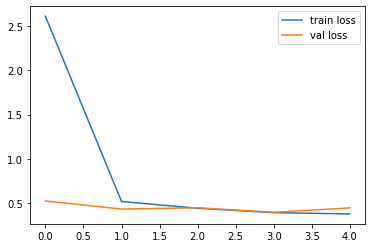

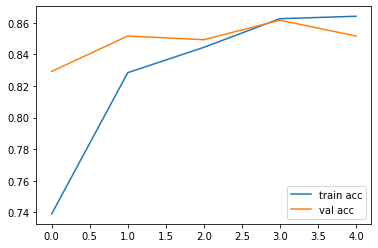

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r.history['accuracy'],label='train acc')
plt.plot(r.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_loss')

In [67]:
img=image.load_img('dataset/X_train/image336.jpg',target_size=(224,224))

In [68]:
x=image.img_to_array(img)
x=x/255
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [69]:
model.predict(img_data)

array([[0.16947944, 0.04200602, 0.07460602, 0.69407946, 0.00660777,
        0.01322133]], dtype=float32)

In [70]:
prediction = np.argmax(model.predict(img_data), axis=1)

In [71]:
predicted_class = str(prediction[0])

In [72]:
for key,value in target_dict.items():
    if predicted_class == value:
        predictionText = "Post is related to " + key

In [73]:
predictionText

'Post is related to Candle'

In [66]:
model.save('inception_v3_model1.h5')

# Xception model

In [ ]:
xception_model = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in xception_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(xception_model.output)

In [ ]:
x = Dense(512,activation='relu')(x)

In [ ]:
prediction = Dense(6,activation='softmax')(x)

In [ ]:
model = Model(inputs=xception_model.input,outputs=prediction)

In [ ]:
model.summary()

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
r = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)

In [ ]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r.history['accuracy'],label='train acc')
plt.plot(r.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_loss')

In [ ]:
model.save('xception_model.h5')

In [74]:
from tensorflow.keras.models import load_model
model1 = load_model('xception_model.h5')

In [88]:
img=image.load_img('dataset/X_train/image411.jpg',target_size=(224,224))

In [89]:
x=image.img_to_array(img)
x=x/255
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [90]:
model.predict(img_data)

array([[0.1114144 , 0.07091591, 0.03611097, 0.71258456, 0.00978677,
        0.05918736]], dtype=float32)

In [91]:
prediction = np.argmax(model.predict(img_data), axis=1)

In [93]:
predicted_class = str(prediction[0])

In [94]:
for key,value in target_dict.items():
    if predicted_class == value:
        predictionText = "Post is related to " + key

In [95]:
predictionText

'Post is related to Candle'

# VGG16

In [ ]:
vgg16_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg16_model.output)

In [ ]:
x = Dense(512,activation='relu')(x)

In [ ]:
prediction = Dense(6,activation='softmax')(x)

In [ ]:
model1 = Model(inputs=vgg16_model.input,outputs=prediction)

In [ ]:
model1.summary()

In [ ]:
model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
r1 = model1.fit_generator(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)

In [ ]:
plt.plot(r1.history['loss'],label='train loss')
plt.plot(r1.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r1.history['accuracy'],label='train acc')
plt.plot(r1.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_loss')

In [ ]:
model1.save('vgg16_model.h5')

# VGG19

In [ ]:
vgg19_model = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg19_model.output)

In [ ]:
x = Dense(512,activation='relu')(x)

In [ ]:
prediction = Dense(6,activation='softmax')(x)

In [ ]:
model2 = Model(inputs=vgg19_model.input,outputs=prediction)

In [ ]:
model2.summary()

In [ ]:
model2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
r2 = model2.fit_generator(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)

In [ ]:
plt.plot(r2.history['loss'],label='train loss')
plt.plot(r2.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r2.history['accuracy'],label='train acc')
plt.plot(r2.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_loss')

In [ ]:
model2.save('vgg19_model.h5')